In [4]:
import torch
import torchvision
from torchvision.utils import save_image

In [5]:
import os
try: 
    os.mkdir("/models_conv") 
except OSError as error: 
    print(error)
try: 
    os.mkdir("/images_conv_gan") 
except OSError as error: 
    print(error)
try: 
    os.mkdir("/samples_conv_gan") 
except OSError as error: 
    print(error)

[Errno 17] File exists: '/models_conv'
[Errno 17] File exists: '/images_conv_gan'
[Errno 17] File exists: '/samples_conv_gan'


In [6]:
print ('Available devices ', torch.cuda.device_count())

Available devices  1


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data_raw=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformation)
test_data_raw=torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=transformation)
train_data=DataLoader(train_data_raw,batch_size=512,shuffle=True)
test_data=DataLoader(test_data_raw,batch_size=512,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
test=next(iter(train_data))
print(test[0][0].shape)
class_names=train_data_raw.classes
print(class_names)

torch.Size([1, 28, 28])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [10]:
import torch.nn as nn
class Discriminator(nn.Module):
    
    def __init__(self, z_dim=10, image_channel=1):
        super().__init__()
        self.layers=nn.Sequential(
             #block1
            nn.Conv2d(image_channel, 16, 4, 2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            #block 2
            nn.Conv2d(16, 16*2, 3, 2),
            nn.BatchNorm2d(16*2),
            nn.LeakyReLU(0.2, inplace=True),
            #block 3
            nn.Conv2d(16*2, 16*4, 4, 1),
            nn.BatchNorm2d(16*4),
            nn.LeakyReLU(0.2, inplace=True),

            #final layer
            nn.Conv2d(16*4, image_channel, 3, 2),
            

           
        )
    
    def forward(self, x: torch.Tensor):
        x=self.layers(x)
        return x.view(len(x), -1)

discriminator=Discriminator()


In [11]:
class Generator(nn.Module):
    def __init__(self,z_dim, image_channel):
        super(Generator, self).__init__() 
        self.z_dim=z_dim
        self.layers=nn.Sequential(
            #block1
            nn.ConvTranspose2d(z_dim, 64*4, 3, 2),
            nn.BatchNorm2d(64*4),
            nn.ReLU(inplace=True),
            #block 2
            nn.ConvTranspose2d(64*4, 64*2, 4, 1),
            nn.BatchNorm2d(64*2),
            nn.ReLU(inplace=True),
            #block 3
            nn.ConvTranspose2d(64*2, 64, 3, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            #final layer
            nn.ConvTranspose2d(64, image_channel, 4, 2),
            nn.Tanh()
        )
    
    # forward method
    def forward(self, x): 
        x = x.view(len(x), self.z_dim, 1, 1)
        return self.layers(x)

generator=Generator(64,1)
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(2, 2))
  )
)

In [12]:
def gen_train_step(generator:  torch.nn.Module,
                   discriminator: torch.nn.Module,
               criterion: torch.nn.Module, 
               gen_optimizer: torch.optim.Optimizer):
        
        
        gen_optimizer.zero_grad()

        z = torch.randn(512, 64, device=device)
        y = torch.ones(512, 1, device=device)

        gen_output = generator(z)
        disc_output = discriminator(gen_output)
        gen_loss = criterion(disc_output, y)

        # gradient backprop & optimize ONLY gen parameters
        gen_loss.backward()
        gen_optimizer.step()
        return gen_loss.data.item()


def train_step(discriminator: torch.nn.Module,
               generator:  torch.nn.Module,
               dataloader: torch.utils.data.DataLoader, 
               criterion: torch.nn.Module, 
               disc_optimizer: torch.optim.Optimizer,
               gen_optimizer: torch.optim.Optimizer):
    # Put model in train mode
    discriminator.train()
    generator.train()
    
    # Setup train loss and train accuracy values
    gen_train_loss, disc_train_loss = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X=X.to(device)
        
        disc_optimizer.zero_grad()
        
        # 1. calc real loss
        y_pred = discriminator(X)
        
        ones=torch.ones(y_pred.size(0),1, device=device)
        real_loss = criterion(y_pred, ones)
        
        
        #2. calc fake loss
        z = torch.randn(X.size(0), 64, device=device)
        fake_output=generator(z)
       
        fake_pred=discriminator(fake_output)
        zeroes=torch.zeros(fake_pred.size(0),1, device=device)
        fake_loss=criterion(fake_pred, zeroes)
    



        
       
       

        # 3. Loss backward
        real_loss.backward(retain_graph=True)
        fake_loss.backward(retain_graph=True)

        # 4. Optimizer step for disc
        disc_optimizer.step()
        
        #train the generator now
        gen_train_loss+=gen_train_step(discriminator=discriminator,
                      generator=generator,
                      criterion=criterion,
                      gen_optimizer=gen_optimizer)
        disc_train_loss+=real_loss.data.item()+fake_loss.data.item()

        
       

    # Adjust metrics to get average loss and accuracy per batch 
    gen_train_loss = gen_train_loss / len(dataloader)
    disc_train_loss = disc_train_loss / len(dataloader)
    return gen_train_loss, disc_train_loss

In [13]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(discriminator: torch.nn.Module,
          generator:  torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          epochs: int = 5):
    discriminator=discriminator.to(device)
    generator=generator.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    beta_1 = 0.5         
    beta_2 = 0.999
    disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=0.0002, betas=(beta_1, beta_2))
    gen_optimizer=torch.optim.Adam(params=generator.parameters(), lr=0.0002, betas=(beta_1, beta_2))
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "sample_images":[]
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(discriminator=discriminator,
                                           generator=generator,
                                           dataloader=train_dataloader,
                                           criterion=loss_fn,
                                           disc_optimizer=disc_optimizer,
                                           gen_optimizer=gen_optimizer)
        
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"disc_train_loss: {train_loss:.4f} | "
            f"gen_train_loss: {train_acc:.4f} | "
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        
        if epoch%5==0:
            tempz = torch.randn(25, 64, device=device)
            generator.eval()
            indexTemp=0
            sample_image=generator(tempz)
            for generated in sample_image:
                indexTemp+=1
                save_image(generated.view(generated.size(0), 1, 28, 28), '/images_conv_gan/sample_'+str(epoch)+'_e_'+str(indexTemp) + '.png')

       

    # 6. Return the filled results at the end of the epochs
    discriminator=discriminator.to('cpu')
    generator=generator.to('cpu')
    return results

In [14]:

# Set number of epochs
NUM_EPOCHS = 100





# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(discriminator=discriminator,
                        generator=generator, 
                        train_dataloader=train_data,
                        test_dataloader=test_data,
                        epochs=NUM_EPOCHS)
torch.save(discriminator.state_dict(), '/models_conv/d_10')
torch.save(generator.state_dict(), '/models_conv/g_10')
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | disc_train_loss: 0.7090 | gen_train_loss: 1.3117 | 
Epoch: 2 | disc_train_loss: 0.8090 | gen_train_loss: 1.0633 | 
Epoch: 3 | disc_train_loss: 1.1350 | gen_train_loss: 0.6966 | 
Epoch: 4 | disc_train_loss: 1.7510 | gen_train_loss: 0.3776 | 
Epoch: 5 | disc_train_loss: 2.4038 | gen_train_loss: 0.2009 | 
Epoch: 6 | disc_train_loss: 2.9714 | gen_train_loss: 0.1149 | 
Epoch: 7 | disc_train_loss: 3.3418 | gen_train_loss: 0.0749 | 
Epoch: 8 | disc_train_loss: 3.1334 | gen_train_loss: 0.3606 | 
Epoch: 9 | disc_train_loss: 2.8976 | gen_train_loss: 0.4845 | 
Epoch: 10 | disc_train_loss: 2.6629 | gen_train_loss: 0.5390 | 
Epoch: 11 | disc_train_loss: 1.8189 | gen_train_loss: 0.8670 | 
Epoch: 12 | disc_train_loss: 2.0941 | gen_train_loss: 0.6574 | 
Epoch: 13 | disc_train_loss: 1.5666 | gen_train_loss: 0.9522 | 
Epoch: 14 | disc_train_loss: 1.6183 | gen_train_loss: 0.8168 | 
Epoch: 15 | disc_train_loss: 1.4462 | gen_train_loss: 1.0161 | 
Epoch: 16 | disc_train_loss: 1.4092 | gen_train_l

In [15]:
z = torch.randn(25, 64)

sample_images = generator(z)


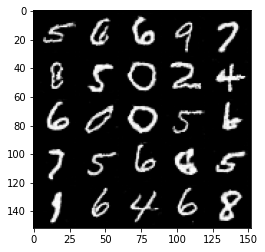

In [16]:
index=0
for generated in sample_images:
    index+=1
    save_image(generated.view(generated.size(0), 1, 28, 28), '/samples_conv_gan/sample_'+str(index) + '.png')

from torchvision.utils import make_grid
from matplotlib import pyplot as plt
def show_tensor_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()
show_tensor_images(sample_images)

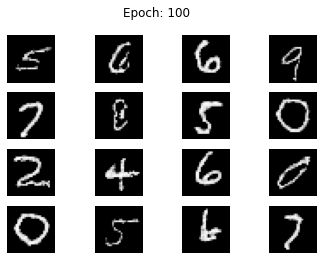

In [21]:
from matplotlib import pyplot
import matplotlib.image as mpimg
import imageio
def save_plot(examples, n,index, filenames):
    
    
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i], cmap=pyplot.get_cmap('gray'))
        
    #pyplot.show()
    pyplot.suptitle("Epoch: "+str(index))
    pyplot.savefig('/samples_conv_gan/gan_mnst_graph_'+str(index)+".png")
    filenames.append('/samples_conv_gan/gan_mnst_graph_'+str(index)+".png")

index=0
filenames=[]


for epoch in range(NUM_EPOCHS//5):
    images = []
    for ind in range(20):
        images.append( mpimg.imread('/images_conv_gan/sample_'+str(epoch*5)+'_e_'+str(ind+1) + '.png'))
    
    save_plot(images,4, epoch*5,filenames)
images=[]
for ind in range(20):
    images.append( mpimg.imread('/samples_conv_gan/sample_'+str(ind+1) + '.png'))
save_plot(images,4, 100,filenames)

In [22]:
import imageio
images = []

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/movieConv.gif', images,duration=0.5)

<ipython-input-22-21008747cd5e>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [23]:
print(discriminator)

Discriminator(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(2, 2))
  )
)


In [24]:
print(generator)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (10): Tanh()
  )
)
